# Task1: Process and construct input for DGCNN

In [50]:
# NetVLAD
from __future__ import print_function
import random
from os.path import join, isfile

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import numpy as np
import netvlad

def VLAD_for_single_image(img):
    cuda = False
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run with --nocuda")

    device = torch.device("cuda" if cuda else "cpu")

    default_seed = 123
    random.seed(default_seed)
    np.random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed(default_seed)

#     print('===> Loading data')
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
    ])
    input = preprocess(img)
    input = input.unsqueeze(0)
#     print('Input image shape: {}'.format(input.shape))

#     print('===> Building model')

    pretrained = True

    encoder_dim = 512
    encoder = models.vgg16(pretrained=pretrained)
    # capture only feature part and remove last relu and maxpool
    layers = list(encoder.features.children())[:-2]

    if pretrained:
        # if using pretrained then only train conv5_1, conv5_2, and conv5_3
        for l in layers[:-5]: 
            for p in l.parameters():
                p.requires_grad = False


    encoder = nn.Sequential(*layers)
    model = nn.Module() 
    model.add_module('encoder', encoder)

    default_num_clusters = 64
    defauly_vladv2 = False
#     print('NetVLAD setting:\nnum_clusters: {} dim: {} vladv2: {}'.format(default_num_clusters, encoder_dim, defauly_vladv2))
    net_vlad = netvlad.NetVLAD(num_clusters=default_num_clusters, dim=encoder_dim, vladv2=defauly_vladv2)
    model.add_module('pool', net_vlad)

    checkpoint_path = 'vgg16_netvlad_checkpoint'
    resume_ckpt = join(checkpoint_path, 'checkpoints', 'checkpoint.pth.tar')

    if isfile(resume_ckpt):
#         print("=> loading checkpoint '{}'".format(resume_ckpt))
        checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
        start_epoch = checkpoint['epoch']
        best_metric = checkpoint['best_score']
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(device)
#         print("=> loaded checkpoint '{}' (epoch {})"
#                 .format(resume_ckpt, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume_ckpt))

#     print('===> Running evaluation step')
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 
#     print('VLAD encoding: {}'.format(vlad_encoding))
#     print('VLAD encoding shape: {}'.format(vlad_encoding.shape))
    return vlad_encoding

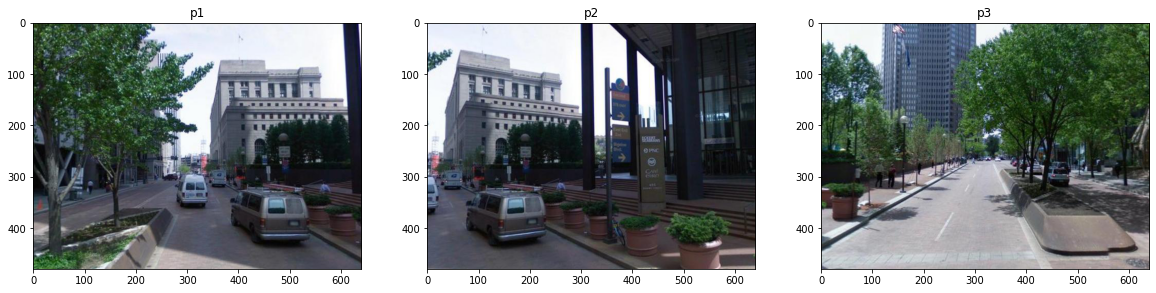

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
p1 = Image.open('./000/q1.jpg')
p2 = Image.open('./000/q2.jpg')
p3 = Image.open('./000/q3.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)
plt.subplot(1, 3, 2)
plt.title('p2')
plt.imshow(p2)
plt.subplot(1, 3, 3)
plt.title('p3')
plt.imshow(p3)

In [144]:
print(VLAD_for_single_image(p1))
print(VLAD_for_single_image(p2))
print(VLAD_for_single_image(p3))
vlad_p1 = VLAD_for_single_image(p1)
torch.flatten(vlad_p1)

tensor([[ 7.1684e-04,  6.6961e-03,  4.6200e-04,  ...,  1.1777e-02,
          5.3187e-03, -8.2065e-05]])
tensor([[ 0.0008,  0.0054, -0.0057,  ...,  0.0049,  0.0074, -0.0076]])
tensor([[ 0.0003,  0.0174,  0.0017,  ...,  0.0061,  0.0056, -0.0020]])


tensor([ 7.1684e-04,  6.6961e-03,  4.6200e-04,  ...,  1.1777e-02,
         5.3187e-03, -8.2065e-05])

In [26]:
import os
from os.path import join, isfile
 
# Get the list of all files and directories
# in the root directory
path = "./demo10/"
dir_list = os.listdir(path)
 
print("Files and directories in '", path, "' :")
 
# print the list
print(dir_list)

Files and directories in ' ./demo10/ ' :
['0ad2d3a7-79e2-2212-9a1b-8737842a24e2', '0ad2d382-79e2-2212-98b3-641bf9d552c1', '0ad2d3a5-79e2-2212-9a9e-2502a05fa678', '0ad2d3a1-79e2-2212-9b99-a96495d9f7fe', '0ad2d3a3-79e2-2212-9a51-9094be707ec2', '0ad2d39d-79e2-2212-99aa-1e95c5b94289', '0ad2d38f-79e2-2212-98d2-9b5060e5e9b5', '0ad2d39b-79e2-2212-99ae-830c292cd079', '0ad2d384-79e2-2212-9b18-72b44eb5463f', '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca']


In [ ]:
from dataclasses import dataclass
from typing import Union, List
from scipy.spatial import distance
test = False

@dataclass
class vertex:
    ind: int # index, unique within single graph
    vlad_emb: torch.Tensor # vlad embedding
    pos: torch.Tensor # 3D position
    deg: int = None # number of neighbors
    nbs: List[int] = None # neighbors
        
dataset = [] # a set of graphes
for dir in dir_list[0:2]: # Let's try 2-classification right now
    metaf_path = join('demo10',dir,'sequence','_info.txt')
    metaf = open(metaf_path,"r+")
    metaf.seek(0)
    metaf_lines = metaf.readlines()
    size = int(metaf_lines[-1].split()[-1])
    print('scene: {} size: {}'.format(dir, size))
    metaf.close()
    num_v = 7 # number of vertices in each graph
    step = size // num_v # uniform interval length 
    for s in range(step):
        # each graph
        frames = ['0'*(6-len(str(x)))+str(x) for x in range(s, size, step)]
        print(s)
        pos_list = []
        v_dic = {}
        for i, frame in enumerate(frames):
            # each vertex
            rgb_file = 'frame-' + frame + '.color.jpg'
            pose_file = 'frame-' + frame + '.pose.txt'
            rgb_file_path = join('demo10', dir, 'sequence', rgb_file)
            pose_file_path = join('demo10', dir, 'sequence', pose_file)
            # 1 get vlad encoding 
            img = Image.open(rgb_file_path)
            vlad_emb = torch.flatten(VLAD_for_single_image(img))
            if test: print('vlad_embbeding: {}'.format(vlad_emb.shape))
            # 2 get 3D-position
            pose_matrix = np.loadtxt(pose_file_path, dtype=float)
            pos = torch.from_numpy(pose_matrix[0:3,-1])
            if test: print('3D position: {}'.format(pos))
            pos_list.append(pos)
            # 3 initialize vertex
            v = vertex(i, vlad_emb, pos)
            v_dic[i] = v
            if test: print(v)
        if test: print(v_dic)
        pos_matrix = torch.stack(pos_list)
        if test: print('3D-position matrix: {}'.format(pos_matrix))
        dis_matrix = distance.cdist(pos_matrix, pos_matrix, 'euclidean')
        if test: print(dis_matrix)
        threshold = np.sum(dis_matrix) / (len(frames)*(len(frames) - 1))
        if test: print(threshold)
        edge_matrix_raw = dis_matrix <= threshold
        f_diag = np.ones((len(frames), len(frames)))
        np.fill_diagonal(f_diag, 0)
        if test: print(f_diag)
        edge_matrix = np.logical_and(edge_matrix_raw, f_diag)
        if test: print(edge_matrix)
        deg_list = np.sum(edge_matrix, axis=0)
        if test: print(deg_list)
        for i, frame in enumerate(frames):
            v_dic[i].deg = deg_list[i]
            v_dic[i].nbs = np.where(edge_matrix[i])[0]
        if test: print(v_dic)
        dataset.append((dir, v_dic))
print(dataset)

In [143]:
import random
random.shuffle(dataset)

In [ ]:
temp = dataset[1]
temp

In [162]:
file1 = open("myfile.txt","w")
L = ['323',"This is Paris \n",'432'] 
file1.writelines(L)
file1.close()
  
# Append-adds at last
file1 = open("myfile.txt","a")#append mode
# file1.write(str(temp[1][0].nbs))
s = " ".join(map(str, temp[1][0].nbs))
file1.write(s+'\n')
s = " ".join(map(str, temp[1][0].vlad_emb.numpy()))
file1.write(s)
file1.close()

In [171]:
f = open('demo2.txt','w')
f.write(str(len(dataset))+'\n')
f.close()
for d in dataset:
    if d[0] == '0ad2d3a7-79e2-2212-9a1b-8737842a24e2':
        label = '0'
    else:
        label = '1'
#     label = d[0]
    graph = d[1]
    f = open('demo2.txt','a')
    f.write(str(len(graph)) + ' ' + label + '\n')
    tag = '0'
    for i, v in graph.items():
        nbs = " ".join(map(str, v.nbs))
        vlad_emb = " ".join(map(str, v.vlad_emb.numpy()))
        f.write(" ".join([tag, str(v.deg), nbs, vlad_emb]) + '\n')

In [ ]:
!head -3 demo2.txt

In [181]:
d_size = len(dataset)
ind_list = [x for x in range(d_size)]
for i in range(1,11):
    test_file = 'test_idx-' + str(i) + '.txt'
    train_file = 'train_idx-' + str(i) + '.txt'
    test_path = join('pytorch_DGCNN-master', 'data', 'DEMO2', '10fold_idx', test_file)
    train_path = join('pytorch_DGCNN-master', 'data', 'DEMO2', '10fold_idx', train_file)
    random.shuffle(ind_list)
    with open(train_path, 'w') as f:
        for ind in ind_list[:60]:
            f.write("{}\n".format(ind))
    with open(test_path, 'w') as f:
        for ind in ind_list[60:]:
            f.write("{}\n".format(ind))

In [194]:
%cd pytorch_DGCNN-master
!pwd

/home/igor/Desktop/tao/tisl/week3/pytorch_DGCNN-master
/home/igor/Desktop/tao/tisl/week3/pytorch_DGCNN-master


In [195]:
!./run_DGCNN.sh DEMO2 1 11

====== begin of gnn configuration ======
| msg_average = 0
======   end of gnn configuration ======
Namespace(batch_size=1, conv1d_activation='ReLU', data='DEMO2', dropout=True, edge_feat_dim=0, extract_features=False, feat_dim=0, fold=1, gm='DGCNN', hidden=128, latent_dim=[32, 32, 32, 1], learning_rate=1e-05, max_lv=4, mode='gpu', num_class=0, num_epochs=100, out_dim=0, printAUC=False, seed=1, sortpooling_k=0.6, test_number=11)
loading data
# classes: 2
# maximum node tag: 1
# train: 60, # test: 11
k used in SortPooling is: 10
Initializing DGCNN
loss: 0.69450 acc: 0.00000: 100%|████████████| 60/60 [00:00<00:00, 60.83batch/s]
average training of epoch 0: loss 0.69128 acc 0.48333 auc 0.00000
loss: 0.67977 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 304.63batch/s]
average test of epoch 0: loss 0.68692 acc 0.72727 auc 0.00000
loss: 0.67014 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 148.94batch/s]
average training of epoch 1: loss 0.68987 acc 0.61667 auc 0.00000
loss: 0.67

loss: 0.56168 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 287.34batch/s]
average test of epoch 24: loss 0.60749 acc 0.72727 auc 0.00000
loss: 0.58436 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 171.99batch/s]
average training of epoch 25: loss 0.60798 acc 0.71667 auc 0.00000
loss: 0.54831 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 300.66batch/s]
average test of epoch 25: loss 0.59860 acc 0.72727 auc 0.00000
loss: 0.76506 acc: 0.00000: 100%|███████████| 60/60 [00:00<00:00, 150.99batch/s]
average training of epoch 26: loss 0.59635 acc 0.70000 auc 0.00000
loss: 0.53735 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 275.87batch/s]
average test of epoch 26: loss 0.58881 acc 0.72727 auc 0.00000
loss: 0.50643 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 164.59batch/s]
average training of epoch 27: loss 0.59024 acc 0.70000 auc 0.00000
loss: 0.52422 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 290.05batch/s]
average test of epoch 27: loss 0.57756 acc 

loss: 0.50336 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 167.76batch/s]
average training of epoch 51: loss 0.21823 acc 1.00000 auc 0.00000
loss: 0.08074 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 280.63batch/s]
average test of epoch 51: loss 0.22266 acc 1.00000 auc 0.00000
loss: 0.12235 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 163.90batch/s]
average training of epoch 52: loss 0.20834 acc 1.00000 auc 0.00000
loss: 0.07555 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 278.50batch/s]
average test of epoch 52: loss 0.20805 acc 1.00000 auc 0.00000
loss: 0.03151 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 148.23batch/s]
average training of epoch 53: loss 0.19468 acc 1.00000 auc 0.00000
loss: 0.06880 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 297.26batch/s]
average test of epoch 53: loss 0.19796 acc 1.00000 auc 0.00000
loss: 0.35561 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 169.28batch/s]
average training of epoch 54: loss 0.18768 

loss: 0.00892 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 290.67batch/s]
average test of epoch 77: loss 0.05061 acc 1.00000 auc 0.00000
loss: 0.00018 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 159.71batch/s]
average training of epoch 78: loss 0.05589 acc 1.00000 auc 0.00000
loss: 0.00879 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 274.89batch/s]
average test of epoch 78: loss 0.04562 acc 1.00000 auc 0.00000
loss: 0.00062 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 155.71batch/s]
average training of epoch 79: loss 0.06026 acc 1.00000 auc 0.00000
loss: 0.00845 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 271.00batch/s]
average test of epoch 79: loss 0.04218 acc 1.00000 auc 0.00000
loss: 0.00387 acc: 1.00000: 100%|███████████| 60/60 [00:00<00:00, 161.54batch/s]
average training of epoch 80: loss 0.03734 acc 1.00000 auc 0.00000
loss: 0.00771 acc: 1.00000: 100%|███████████| 11/11 [00:00<00:00, 270.09batch/s]
average test of epoch 80: loss 0.03987 acc 